In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D 
import numpy as np

In [2]:
xlsx = pd.ExcelFile('scc_election.xlsx')
table_of_contents = pd.read_excel(xlsx, 0, skiprows=3)

scc_primary = {}
for i, name in enumerate(table_of_contents['Contest']):
    if i == 0:
        scc_primary['{}'.format(str(name))] = pd.read_excel(xlsx, i+1)
    else:
        scc_primary['{}'.format(str(name))] = pd.read_excel(xlsx, i+1, header=[0,1])

In [5]:
df_amount = 40
page = 'Measure A - City of Santa Clara Charter Amendment (Vote For 1)'
key = 'YES'

df = scc_primary['Registered Voters']
df = df.copy()[df['County'].str.contains("MAIL") == False]

df['Voter Turnout'] = [float(str(i).strip('%')) for i in df['Voter Turnout']]
df = df.dropna(how='any')
df = df.drop(df.tail(1).index)
df = df.sort_values('Voter Turnout', ascending=True)

df_joined = df.join(scc_primary['{}'.format(page)], on='County', how='left')
df_joined['Percent Votes'] = df_joined['{}'.format(key),'Total Votes'] / df_joined.iloc[:,-1]
df_joined = df_joined.dropna()
df_joined = df_joined.head(df_amount)

cmap = 'RdBu'
color = cm.RdBu(df_joined['Percent Votes'])

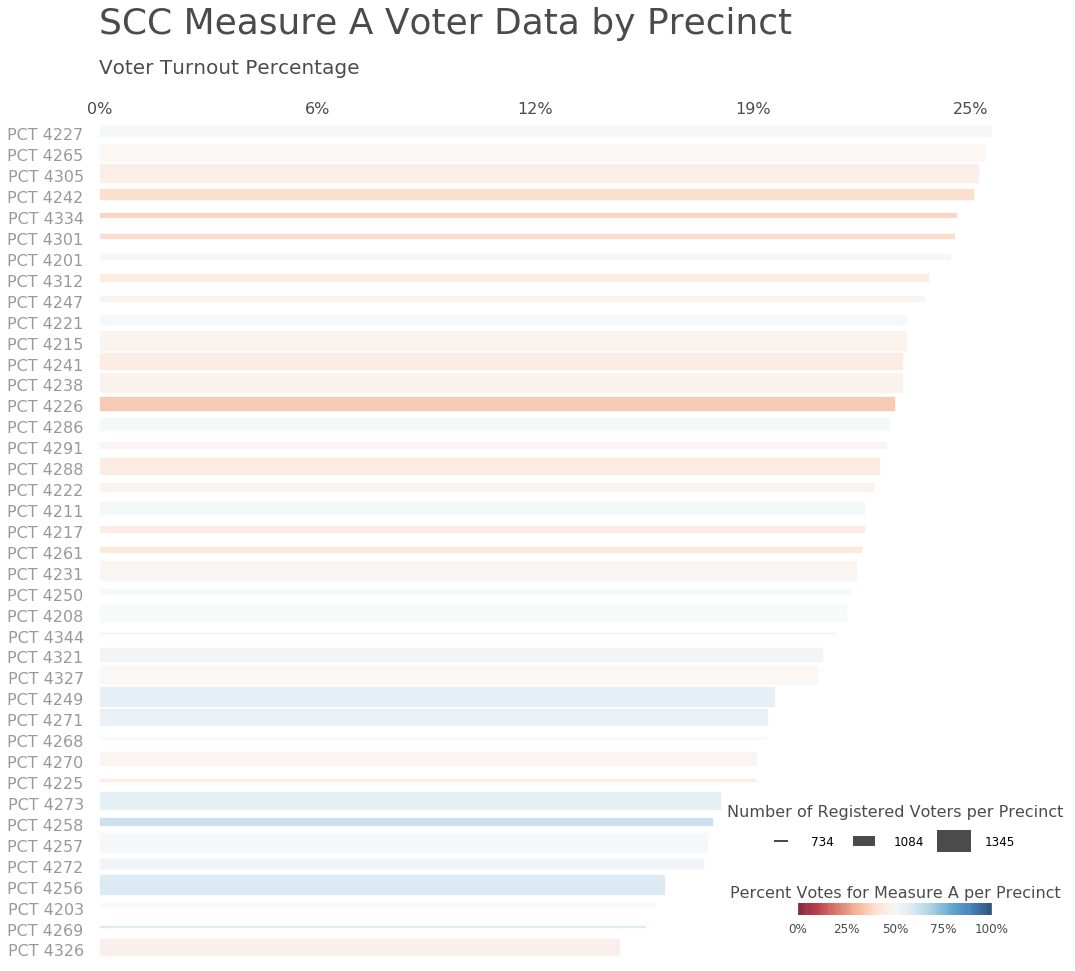

In [7]:
alpha = .7

fig = plt.figure(figsize=(16,5+len(df_joined)/4))
ax = fig.add_subplot(111)

df_joined['Voter Turnout'].plot(kind='barh', ax=ax, alpha=.7,
                             legend=False, color=color,
                             edgecolor='w', xlim=(0, max(df_joined['Voter Turnout'])),
                             title='SCC Measure A Voter Data by Precinct')
ax.grid(False)
ax.set_frame_on(False)

ax.set_title(ax.get_title(), fontsize=36, alpha=alpha, ha='left', y=1.8)
plt.subplots_adjust(top=0.9)
ax.title.set_position((0, 1.10))

ax.xaxis.set_label_position('top')
ax.set_xlabel('Voter Turnout Percentage', fontsize=20, alpha=alpha, ha='left')
ax.xaxis.set_label_coords(0, 1.06)
ax.xaxis.tick_top()
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
xticks = np.linspace(0,
                     int(max(df_joined['Voter Turnout'])),
                     int(max(df_joined['Voter Turnout'])/5.))
ax.xaxis.set_ticks(xticks)
ax.set_xticklabels(['{:.0f}%'.format(val) for val in xticks], fontsize=16, alpha=alpha)

yticks = df_joined['County']
ax.set_yticklabels(yticks, fontsize=16, alpha=.4)
ax.yaxis.set_tick_params(pad=12)  


hmin, hmax = 0.1, 1.0
xmin, xmax = min(df_joined['Registered Voters']), max(df_joined['Registered Voters'])

f = lambda x: hmin + (hmax-hmin)*(x-xmin)/(xmax-xmin)
heights = [f(x) for x in df_joined['Registered Voters']]

for container in ax.containers:
    for i, child in enumerate(container.get_children()):
        child.set_y(child.get_y()- 0.125 + 0.5-heights[i]/2)
        plt.setp(child, height=heights[i])

ax2 = fig.add_subplot(248)
# plt.subplots_adjust(left=.5, right=1.5)
ax2.grid(False)
ax2.set_frame_on(False)
ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.yaxis.set_ticks_position('none')
ax2.xaxis.set_ticks_position('none')

l1 = Line2D([], [], linewidth=2, color='k', alpha=alpha) 
l2 = Line2D([], [], linewidth=10, color='k', alpha=alpha) 
l3 = Line2D([], [], linewidth=22, color='k', alpha=alpha)

labels = [str(min(df_joined['Registered Voters'])), 
          str(int(np.mean(df_joined['Registered Voters']))),
          str(max(df_joined['Registered Voters']))]
 
# Position legend in lower right part
# Set ncol=3 for horizontally expanding legend
leg = ax2.legend([l1, l2, l3], labels, ncol=3, frameon=False, fontsize=12, 
                 bbox_to_anchor=[.5, -.1], loc='center', handlelength=1, 
                 handletextpad=2, columnspacing=2,
                 title='Number of Registered Voters per Precinct')
 
# Customize legend title
# Set position to increase space between legend and labels
plt.setp(leg.get_title(), fontsize=16, alpha=alpha)
leg.get_title().set_position((0, 10))

sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=mpl.colors.Normalize(vmin=0,
                                                     vmax=1))
sm._A = []

cbar = plt.colorbar(sm, ax=ax2, orientation='horizontal',
                    alpha=.25, aspect=16, pad=.25)
cbar.solids.set_edgecolor("face")
cbar.outline.set_visible(False)
cbar.ax.tick_params(labelsize=12)

mytks = np.arange(0,1.1,.25)
cbar.set_ticks(mytks)
cbar.ax.set_xticklabels(['{:.0f}%'.format(a*100) for a in mytks], alpha=alpha)
cbar.ax.set_title('Percent Votes for Measure A per Precinct', alpha=alpha, 
                  fontsize=16)
cbarxtks = plt.getp(cbar.ax.axes, 'xticklines')
plt.setp(cbarxtks, visible=False)
plt.savefig('test.png', bbox_inches='tight', dpi=300)
plt.show()